# Scraping Sold Houses

### Import Lib

In [2]:
import numpy as np
import requests
import os
import time
import re
import pandas as pd
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import box

### Functions

In [13]:
def setup_driver():
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    options.add_argument('--no-sandbox')
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    return driver

def download_image(image_url, location, base_url='https://www.estately.com', save_dir='../data/estately_images/queens'):
    if not image_url.startswith('http'):
        image_url = base_url + image_url
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    filename = "".join([c for c in location if c.isalpha() or c.isdigit() or c == ' ']).rstrip()
    filename = filename.replace(' ', '_') + '.jpg'
    file_path = os.path.join(save_dir, filename)
    try:
        response = requests.get(image_url)
        if response.status_code == 200:
            with open(file_path, 'wb') as file:
                file.write(response.content)
        else:
            filename = None
    except requests.exceptions.RequestException:
        filename = None 
    return filename

def fetch_on_sales_properties(driver, max_images=300, area = 'NY/New_York'):
    properties = []
    image_count = 0
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    property_divs = soup.find_all('div', class_='result-item-info clearfix')
    print('properties found: ', len(property_divs))
    for div in property_divs:
#         if image_count >= max_images:
#             break
        location_tag = div.find('h2', class_='result-address').find('a')
        location = location_tag.text.strip() if location_tag else "No location provided"
        image_tag = div.find('img', class_='listing-card-image')
        detail_link = 'https://www.estately.com' + location_tag['href'] if location_tag else None

        # Price extraction
        price_tag = div.find('p', class_='result-price')
        price = price_tag.text.strip() if price_tag else "Price not listed"
        
        # Property type extraction
        property_type_tag = div.find('h2', class_='result-address').find('small')
        property_type = property_type_tag.text.strip() if property_type_tag else "Property type not listed"
        
        photo_count_tag = div.parent.find('div', class_='photo-count-small')
        photo_count = photo_count_tag.text.strip() if photo_count_tag else "No photo"
        
        broker_tag = div.parent.find('p')
        broker = broker_tag.text.strip() if broker_tag else "No broker listed"
        
        image_url = image_tag.get('data-src', image_tag.get('src', "No image provided")) if image_tag else "No image provided"
        image_name = None
#         image_name = download_image(image_url, location, save_dir=f'../data/estately/img/{area}')

        # Basic details extraction
        basics_grid = div.find('ul', class_='result-basics-grid')
        beds = baths = sqft = lot_size = days_on_site = None 
        if basics_grid:
            for li in basics_grid.find_all('li'):
                text = li.text.strip()
                if 'bed' in text.lower():
                    beds = text.split()[0]
                elif 'bath' in text.lower():
                    baths = text.split()[0]
                elif 'sqft' in text.lower() and not 'lot' in text.lower():
                    sqft = text.split()[0]
                elif 'lot' in text.lower():
                    lot_size = text.split()[0]
                elif 'on site' in text.lower():
                    days_on_site = text.split()[0]
        properties.append({
            'Location': location,
            'Detail Link': detail_link,
            'Image Name': image_name,
            'Price': price,
            'Property Type': property_type,
            'Photo Count': photo_count,
            'Broker': broker,
            'Beds': beds,
            'Baths': baths,
            'Sqft': sqft,
            'Lot Size': lot_size,
            'Days on Site': days_on_site
        })
        image_count += 1
        if image_count % 20 == 0:
            print(f"Scraped {image_count} images.")
    return properties

def fetch_sold_properties(driver, max_images=300, area = 'NY/New_York'):
    properties = []
    image_count = 0
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    property_divs = soup.find_all('div', class_='result-item-info clearfix')
    print('properties found: ', len(property_divs))
    for div in property_divs:
#         if image_count >= max_images:
#             break
        location_tag = div.find('h2', class_='result-address').find('a')
        location = location_tag.text.strip() if location_tag else "No location provided"
        image_tag = div.find('img', class_='listing-card-image')
        detail_link = 'https://www.estately.com' + location_tag['href'] if location_tag else None

        # Price extraction
        price_tag = div.find('p', class_='result-price')
        price = price_tag.text.strip() if price_tag else "Price not listed"
        
        # Property type extraction
        property_type_tag = div.find('h2', class_='result-address').find('small')
        property_type = property_type_tag.text.strip() if property_type_tag else "Property type not listed"
        
        photo_count_tag = div.parent.find('div', class_='photo-count-small')
        photo_count = photo_count_tag.text.strip() if photo_count_tag else "No photo"
        
        broker_tag = div.parent.find('p')
        broker = broker_tag.text.strip() if broker_tag else "No broker listed"
        
        image_url = image_tag.get('data-src', image_tag.get('src', "No image provided")) if image_tag else "No image provided"
        image_name = None
#         image_name = download_image(image_url, location, save_dir=f'../data/estately/img/{area}')

        sold_date_tag = div.find('small', string=re.compile(r'\d{1,2}/\d{1,2}/\d{2}'))
        sold_date = sold_date_tag.get_text(strip=True) if sold_date_tag else 'date not listed'

        # Basic details extraction
        basics_grid = div.find('ul', class_='result-basics-grid')
        beds = baths = sqft = lot_size = None 
        if basics_grid:
            for li in basics_grid.find_all('li'):
                text = li.text.strip()
                if 'bed' in text.lower():
                    beds = text.split()[0]
                elif 'bath' in text.lower():
                    baths = text.split()[0]
                elif 'sqft' in text.lower() and not 'lot' in text.lower():
                    sqft = text.split()[0]
                elif 'lot' in text.lower():
                    lot_size = text.split()[0]
        properties.append({
            'Location': location,
            'Detail Link': detail_link,
            'Image Name': image_name,
            'Price': price,
            'Property Type': property_type,
            'Photo Count': photo_count,
            'Broker': broker,
            'Beds': beds,
            'Baths': baths,
            'Sqft': sqft,
            'Lot Size': lot_size,
            'Sold Date': sold_date
        })
        image_count += 1
        if image_count % 20 == 0:
            print(f"Scraped {image_count} images.")
    return properties

def main(max_images=300, area = 'NY/New_York', scraping_type = None):
    url = f'https://www.estately.com/{area}'
    if scraping_type and 'sold' in scraping_type:
        url += '?only_sold=sold'
    
    print(area)
    driver = setup_driver()
    driver.get(url)
    time.sleep(5)
#     driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
#     time.sleep(5)
    if scraping_type and 'sold' in scraping_type:
        properties = fetch_sold_properties(driver, max_images, area)
    else:
        properties = fetch_on_sales_properties(driver, max_images, area)

    driver.quit()
    df = pd.DataFrame(properties)
    return df

### Get Census Tracts Boundaries

In [4]:
import pandas as pd

# Load the CSV file
csv_file_path = '../docs/HMDACensus.xlsx'
census_data = pd.read_excel(csv_file_path)
print(census_data.head())


   state_code  county_code  census_tract_number  as_of_year  loanN  \
0           1            1                201.0        2017     30   
1           1            1                202.0        2017     34   
2           1            1                203.0        2017     78   
3           1            1                204.0        2017    100   
4           1            1                206.0        2017     83   

   population       GEOID   INTPTLAT   INTPTLON  
0        1948  1001020100  32.481973 -86.491565  
1        2156  1001020200  32.475758 -86.472468  
2        2968  1001020300  32.474024 -86.459703  
3        4423  1001020400  32.471030 -86.444835  
4        3851  1001020600  32.447340 -86.476828  


In [ ]:
import requests
import zipfile
import os

def download_shapefiles(year=2023, entity='tract', resolution='5m', download_dir='shapefiles'):
    base_url = 'https://www2.census.gov/geo/tiger/GENZ{year}/shp/cb_{year}_us_{entity}_{resolution}.zip'
    url = base_url.format(year=year, entity=entity, resolution=resolution)
    print(url)
    # Create download directory if it doesn't exist
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)
    
    # Download the zip file
    zip_file_path = os.path.join(download_dir, f'cb_{year}_us_{entity}_{resolution}.zip')
    response = requests.get(url)
    if response.status_code == 200:
        with open(zip_file_path, 'wb') as file:
            file.write(response.content)
        print(f'Downloaded shapefile to {zip_file_path}')
        
        # Extract the zip file
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(download_dir)
        print(f'Extracted shapefiles to {download_dir}')
    else:
        print(f'Failed to download shapefile. Status code: {response.status_code}')
        print(f'URL attempted: {url}')

# Example usage
download_shapefiles(year=2023, entity='tract', resolution='5m')


In [ ]:
import geopandas as gpd

# Load the shape files
shape_file_path = 'shapefiles/cb_2023_us_tract_5m.shp'
tracts = gpd.read_file(shape_file_path)

# Ensure state_code, county_code, and census_tract are strings
census_data['state_code'] = census_data['state_code'].astype(str).str.zfill(2)
census_data['county_code'] = census_data['county_code'].astype(str).str.zfill(3)
census_data['GEOID'] = census_data['GEOID'].astype(str).str.zfill(10)

tracts['STATEFP'] = tracts['STATEFP'].astype(str).str.zfill(2)
tracts['COUNTYFP'] = tracts['COUNTYFP'].astype(str).str.zfill(3)
tracts['GEOID'] = tracts['GEOID'].astype(str).str.zfill(10)

# merge files
census_tracts = pd.merge(census_data, tracts, left_on=['state_code', 'county_code', 'GEOID'], right_on=['STATEFP', 'COUNTYFP', 'GEOID'])


### Run

In [9]:

def generate_grid_within_boundary(boundary, step=0.002):
    minx, miny, maxx, maxy = boundary.bounds
    grids = []
    x = minx
    while x < maxx:
        y = miny
        while y < maxy:
            grid = box(x, y, x + step, y + step)
            if grid.intersects(boundary):
                grids.append(grid)
                # Plot the grid
                x1, y1, x2, y2 = grid.bounds
                plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'b-')
            y += step
        x += step
    print('Scraping the following tract, total: ', len(grids))
    
    plt.axis('equal')
    plt.show()
    return grids

In [35]:
# Function to scrape properties for each grid
def main_for_census_tract(tract_data, step):
    for index, row in tract_data.iterrows():
        boundary = row['geometry']
        grids = generate_grid_within_boundary(boundary, step)
        for grid in grids:
            minx, miny, maxx, maxy = [round(val, 3) for val in grid.bounds]
            
            # Adjust the main call to use these coordinates
            df_on_sales = main(1, f'{miny},{minx},{maxy},{maxx}')
            print('On sales Scrapped')
            df_sold = main(1, f'{miny},{minx},{maxy},{maxx}', 'sold')
            print('Sold Scrapped')
        if index > 10:
            break
    return df_on_sales, df_sold

Scraping the following tract, total:  2


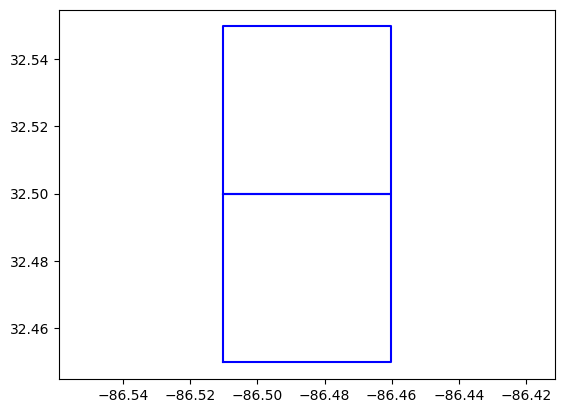

32.45,-86.51,32.5,-86.46
properties found:  3
On sales Scrapped
32.45,-86.51,32.5,-86.46
properties found:  23
Scraped 20 images.
Sold Scrapped
32.5,-86.51,32.55,-86.46
properties found:  2
On sales Scrapped
32.5,-86.51,32.55,-86.46
properties found:  20
Scraped 20 images.
Sold Scrapped
Scraping the following tract, total:  1


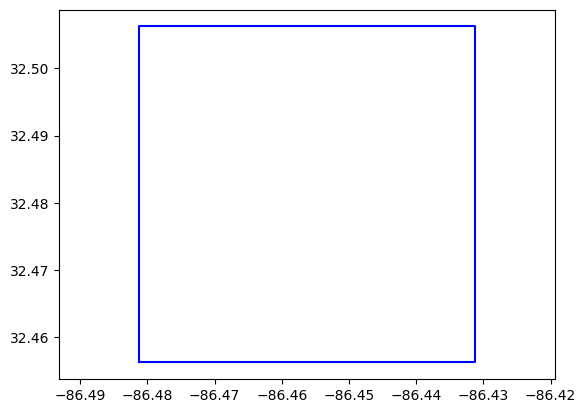

32.456,-86.481,32.506,-86.431
properties found:  14
On sales Scrapped
32.456,-86.481,32.506,-86.431
properties found:  29
Scraped 20 images.
Sold Scrapped
Scraping the following tract, total:  1


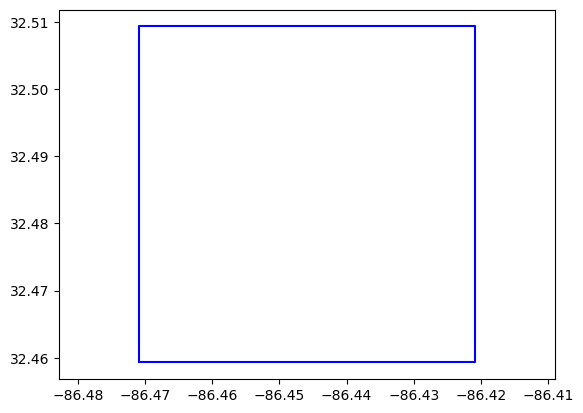

32.459,-86.471,32.509,-86.421
properties found:  14
On sales Scrapped
32.459,-86.471,32.509,-86.421
properties found:  30
Scraped 20 images.
Sold Scrapped
Scraping the following tract, total:  1


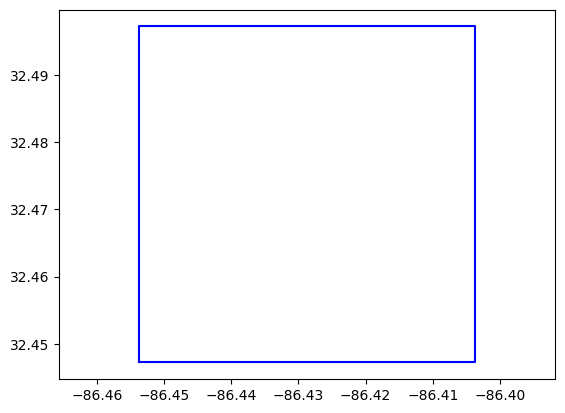

32.447,-86.454,32.497,-86.404
properties found:  15
On sales Scrapped
32.447,-86.454,32.497,-86.404
properties found:  32
Scraped 20 images.
Sold Scrapped
Scraping the following tract, total:  1


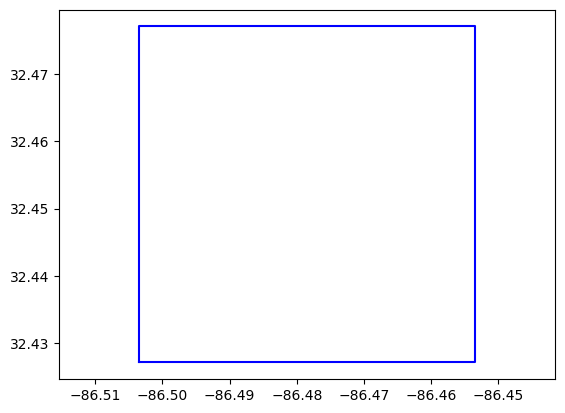

32.427,-86.503,32.477,-86.453
properties found:  5
On sales Scrapped
32.427,-86.503,32.477,-86.453
properties found:  23
Scraped 20 images.
Sold Scrapped
Scraping the following tract, total:  3


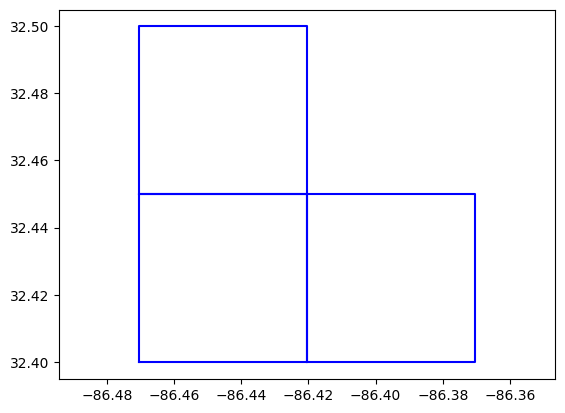

32.4,-86.47,32.45,-86.42
properties found:  14
On sales Scrapped
32.4,-86.47,32.45,-86.42
properties found:  25
Scraped 20 images.
Sold Scrapped
32.45,-86.47,32.5,-86.42
properties found:  14
On sales Scrapped
32.45,-86.47,32.5,-86.42
properties found:  30
Scraped 20 images.
Sold Scrapped
32.4,-86.42,32.45,-86.37
properties found:  11
On sales Scrapped
32.4,-86.42,32.45,-86.37
properties found:  17
Sold Scrapped
Scraping the following tract, total:  10


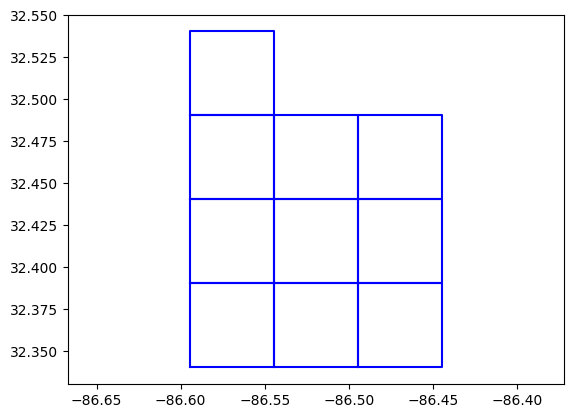

32.34,-86.595,32.39,-86.545
properties found:  0
On sales Scrapped
32.34,-86.595,32.39,-86.545
properties found:  3
Sold Scrapped
32.39,-86.595,32.44,-86.545
properties found:  0
On sales Scrapped
32.39,-86.595,32.44,-86.545
properties found:  3
Sold Scrapped
32.44,-86.595,32.49,-86.545
properties found:  1
On sales Scrapped
32.44,-86.595,32.49,-86.545
properties found:  5
Sold Scrapped
32.49,-86.595,32.54,-86.545
properties found:  3
On sales Scrapped
32.49,-86.595,32.54,-86.545
properties found:  7
Sold Scrapped
32.34,-86.545,32.39,-86.495
properties found:  0
On sales Scrapped
32.34,-86.545,32.39,-86.495
properties found:  1
Sold Scrapped
32.39,-86.545,32.44,-86.495
properties found:  1
On sales Scrapped
32.39,-86.545,32.44,-86.495
properties found:  9
Sold Scrapped
32.44,-86.545,32.49,-86.495
properties found:  1
On sales Scrapped
32.44,-86.545,32.49,-86.495
properties found:  13
Sold Scrapped
32.34,-86.495,32.39,-86.445
properties found:  0
On sales Scrapped
32.34,-86.495,32.39,-8

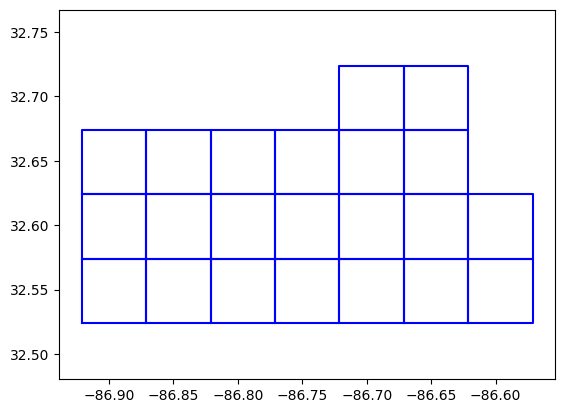

32.524,-86.921,32.574,-86.871
properties found:  1
On sales Scrapped
32.524,-86.921,32.574,-86.871
properties found:  1
Sold Scrapped
32.574,-86.921,32.624,-86.871
properties found:  1
On sales Scrapped
32.574,-86.921,32.624,-86.871
properties found:  9
Sold Scrapped
32.624,-86.921,32.674,-86.871
properties found:  3
On sales Scrapped
32.624,-86.921,32.674,-86.871
properties found:  10
Sold Scrapped
32.524,-86.871,32.574,-86.821
properties found:  1
On sales Scrapped
32.524,-86.871,32.574,-86.821
properties found:  2
Sold Scrapped
32.574,-86.871,32.624,-86.821
properties found:  0
On sales Scrapped
32.574,-86.871,32.624,-86.821
properties found:  2
Sold Scrapped
32.624,-86.871,32.674,-86.821
properties found:  2
On sales Scrapped
32.624,-86.871,32.674,-86.821
properties found:  7
Sold Scrapped
32.524,-86.821,32.574,-86.771
properties found:  0
On sales Scrapped
32.524,-86.821,32.574,-86.771
properties found:  2
Sold Scrapped
32.574,-86.821,32.624,-86.771
properties found:  1
On sales S

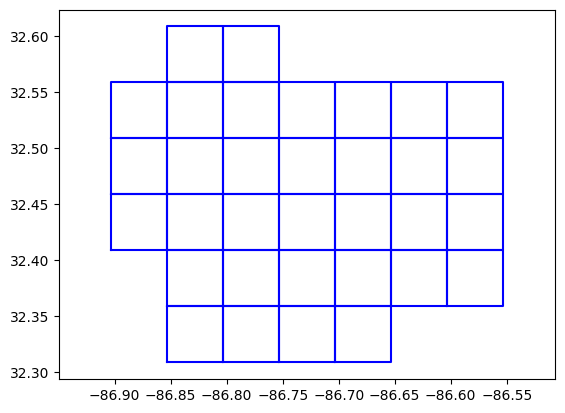

32.409,-86.903,32.459,-86.853
properties found:  1
On sales Scrapped
32.409,-86.903,32.459,-86.853
properties found:  3
Sold Scrapped
32.459,-86.903,32.509,-86.853
properties found:  1
On sales Scrapped
32.459,-86.903,32.509,-86.853
properties found:  4
Sold Scrapped
32.509,-86.903,32.559,-86.853
properties found:  1
On sales Scrapped
32.509,-86.903,32.559,-86.853
properties found:  3
Sold Scrapped
32.309,-86.853,32.359,-86.803
properties found:  0
On sales Scrapped
32.309,-86.853,32.359,-86.803
properties found:  0
Sold Scrapped
32.359,-86.853,32.409,-86.803
properties found:  0
On sales Scrapped
32.359,-86.853,32.409,-86.803
properties found:  0
Sold Scrapped
32.409,-86.853,32.459,-86.803
properties found:  0
On sales Scrapped
32.409,-86.853,32.459,-86.803
properties found:  0
Sold Scrapped
32.459,-86.853,32.509,-86.803
properties found:  0
On sales Scrapped
32.459,-86.853,32.509,-86.803
properties found:  0
Sold Scrapped
32.509,-86.853,32.559,-86.803
properties found:  0
On sales Sc

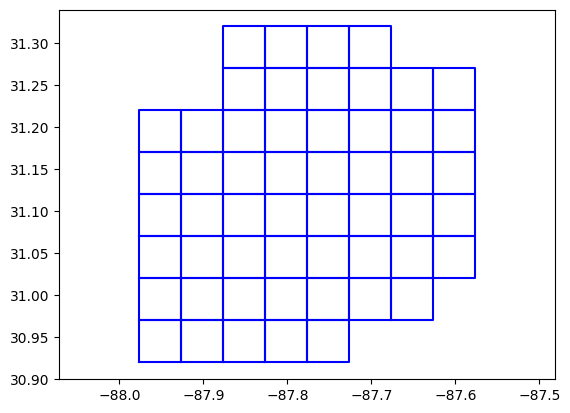

30.919,-87.976,30.969,-87.926
properties found:  0
On sales Scrapped
30.919,-87.976,30.969,-87.926
properties found:  1
Sold Scrapped
30.969,-87.976,31.019,-87.926
properties found:  0
On sales Scrapped
30.969,-87.976,31.019,-87.926
properties found:  0
Sold Scrapped
31.019,-87.976,31.069,-87.926
properties found:  1
On sales Scrapped
31.019,-87.976,31.069,-87.926
properties found:  2
Sold Scrapped
31.069,-87.976,31.119,-87.926
properties found:  1
On sales Scrapped
31.069,-87.976,31.119,-87.926
properties found:  2
Sold Scrapped
31.119,-87.976,31.169,-87.926
properties found:  2
On sales Scrapped
31.119,-87.976,31.169,-87.926
properties found:  2
Sold Scrapped
31.169,-87.976,31.219,-87.926
properties found:  1
On sales Scrapped
31.169,-87.976,31.219,-87.926
properties found:  0
Sold Scrapped
30.919,-87.926,30.969,-87.876
properties found:  6
On sales Scrapped
30.919,-87.926,30.969,-87.876
properties found:  78
Scraped 20 images.
Scraped 40 images.
Scraped 60 images.
Sold Scrapped
30.9

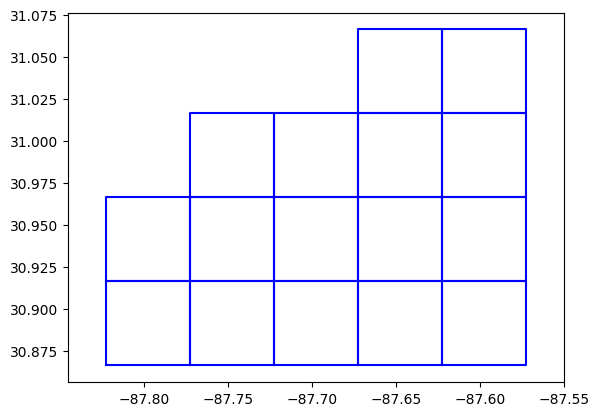

30.866,-87.823,30.916,-87.773
properties found:  70
Scraped 20 images.
Scraped 40 images.
Scraped 60 images.
On sales Scrapped
30.866,-87.823,30.916,-87.773
properties found:  200
Scraped 20 images.
Scraped 40 images.
Scraped 60 images.
Scraped 80 images.
Scraped 100 images.
Scraped 120 images.
Scraped 140 images.
Scraped 160 images.
Scraped 180 images.
Scraped 200 images.
Sold Scrapped
30.916,-87.823,30.966,-87.773
properties found:  55
Scraped 20 images.
Scraped 40 images.
On sales Scrapped
30.916,-87.823,30.966,-87.773
properties found:  200
Scraped 20 images.
Scraped 40 images.
Scraped 60 images.
Scraped 80 images.
Scraped 100 images.
Scraped 120 images.
Scraped 140 images.
Scraped 160 images.
Scraped 180 images.
Scraped 200 images.
Sold Scrapped
30.866,-87.773,30.916,-87.723
properties found:  67
Scraped 20 images.
Scraped 40 images.
Scraped 60 images.
On sales Scrapped
30.866,-87.773,30.916,-87.723
properties found:  200
Scraped 20 images.
Scraped 40 images.
Scraped 60 images.
Sc

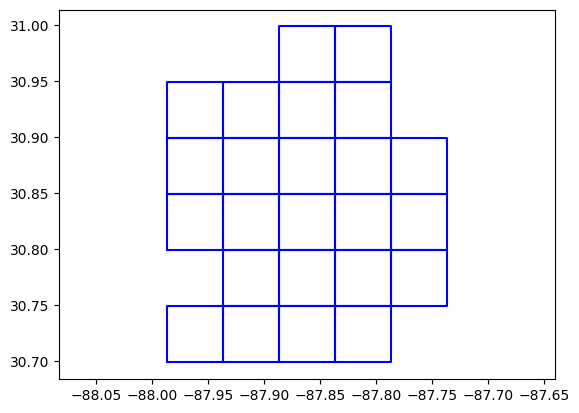

30.699,-87.986,30.749,-87.936
properties found:  7
On sales Scrapped
30.699,-87.986,30.749,-87.936
properties found:  200
Scraped 20 images.
Scraped 40 images.
Scraped 60 images.
Scraped 80 images.
Scraped 100 images.
Scraped 120 images.
Scraped 140 images.
Scraped 160 images.
Scraped 180 images.
Scraped 200 images.
Sold Scrapped
30.799,-87.986,30.849,-87.936
properties found:  0
On sales Scrapped
30.799,-87.986,30.849,-87.936
properties found:  4
Sold Scrapped
30.849,-87.986,30.899,-87.936
properties found:  0
On sales Scrapped
30.849,-87.986,30.899,-87.936
properties found:  4
Sold Scrapped
30.899,-87.986,30.949,-87.936
properties found:  0
On sales Scrapped
30.899,-87.986,30.949,-87.936
properties found:  4
Sold Scrapped
30.699,-87.936,30.749,-87.886
properties found:  106
Scraped 20 images.
Scraped 40 images.
Scraped 60 images.
Scraped 80 images.
Scraped 100 images.
On sales Scrapped
30.699,-87.936,30.749,-87.886
properties found:  200
Scraped 20 images.
Scraped 40 images.
Scraped 

In [36]:
# test
step = 0.05
tract_data = pd.read_csv('tract_data.csv')
tract_data['geometry'] = tract_data['geometry'].apply(wkt.loads)
gpd.GeoDataFrame(tract_data, geometry='geometry')
df_on_sales, df_sold = main_for_census_tract(tract_data, step)

In [37]:
df_on_sales.head()

,Location,Detail Link,Image Name,Price,Property Type,Photo Count,Broker,Beds,Baths,Sqft,Lot Size,Days on Site
0,"0 Delta Woods Drive, Bay Minette, AL",https://www.estately.com/listings/info/0-delta...,None,"$27,000",Land For Sale,1 photo,Land For Sale,–,–,–,None,None
1,"301 W Magnolia Street, Bay Minette, AL",https://www.estately.com/listings/info/301-w-m...,None,"$19,900",Land For Sale,2 photos,Land For Sale,–,–,–,"7,436",None
2,"0 Forest Park Avenue, Bay Minette, AL",https://www.estately.com/listings/info/0-fores...,None,"$39,900",Land For Sale,14 photos,Land For Sale,–,–,–,None,None
3,"45616 Ann Avenue, Bay Minette, AL",https://www.estately.com/listings/info/45616-a...,None,"$252,000",House For Sale,14 photos,House For Sale,3,2,"1,933",None,None
4,"202 W Banyan Street, Bay Minette, AL",https://www.estately.com/listings/info/202-w-b...,None,"$199,900",House For Sale,33 photos,House For Sale,3,2,"1,148","14,113",None


### Demo

Scraping the following tract, total:  280


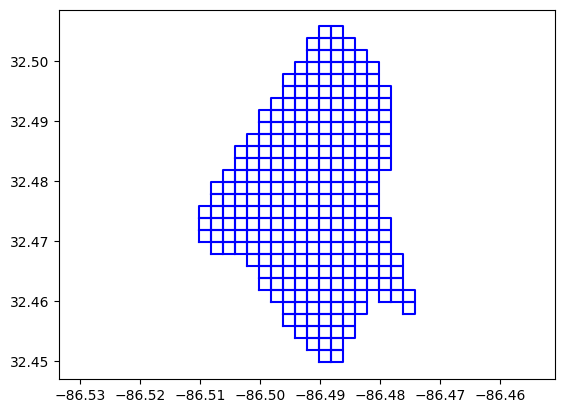

In [33]:
import folium
from shapely.geometry import box, Polygon

# Function to scrape properties for each grid
def main_for_test(tract_data, ind):
    for index, row in tract_data.iterrows():
        if index != ind:
            continue
        boundary = row['geometry']
        m = generate_grid_test(boundary)
        return m
def generate_grid_test(boundary, step=0.002):
    minx, miny, maxx, maxy = boundary.bounds
    grids = []
    x = minx
    while x < maxx:
        y = miny
        while y < maxy:
            grid = box(x, y, x + step, y + step)
            if grid.intersects(boundary):
                grids.append(grid)
                # Plot the grid
                x1, y1, x2, y2 = grid.bounds
                plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'b-')
            y += step
        x += step
    print('Scraping the following tract, total: ', len(grids))
    
    plt.axis('equal')
    plt.show()
    
    # Create a Folium map
    m = folium.Map(location=[(miny + maxy) / 2, (minx + maxx) / 2], zoom_start=12)

    # Draw the boundary on the map
    x, y = boundary.exterior.xy
    folium.PolyLine([(y, x) for x, y in zip(x, y)]).add_to(m)
    return m

m = main_for_test(tract_data, 0)
m

Scraping the following tract, total:  604


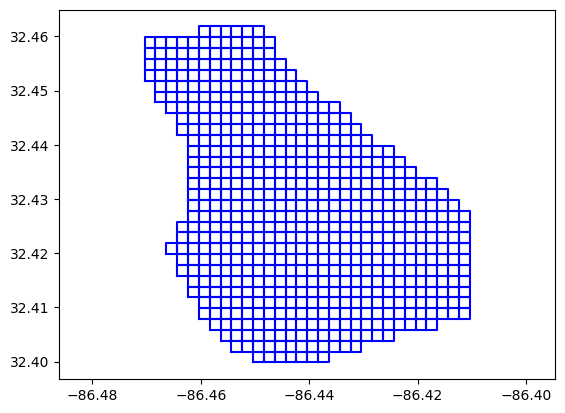

In [24]:
m = main_for_test(tract_data, 5)
m

### for area with population less than 5000, we can use bigger grid
